In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pulp import LpVariable, LpProblem, LpMaximize, LpStatus, value, LpMinimize, GLPK, PULP_CBC_CMD
from itertools import permutations
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)


In [4]:
def lp_problem(marketing_budget):
    # definevariables
    factories = ['A', 'B']
    productions = ['widgets', 'gadgets', 'flugels']
    time_periods = [1, 2, 3, 4, 5]
    # Create all permuations of the production decision variables
    production_combinations = {(f, p, t): LpVariable(f"factory{f}_{p}_{t}", 0, None, cat='Integer')
                               for f in factories for p in productions for t in time_periods}

    storage_combinations = {(f, p, t): LpVariable(f"storage_factory{f}_{p}_{t}", 0, 0 if t==5 else None, cat='Integer')
                                                  for f in factories for p in productions for t in time_periods}

    marketing_combinations = {(p, t): LpVariable(f"marketing_{p}_{t}", 0, None, cat='Integer')
                              for p in productions for t in time_periods[:-1]} 

    overtime_combinations = {(f, t): LpVariable(f"overtime_factory{f}_{t}", 0, None)
                             for f in factories for t in time_periods}
    
    def get_production(factory = None, production = None, time_period = None):
        """
        Helper function for grabbing multiple production variables when needed
        """
        factory = [factory] if factory else factories
        production = [production] if production else productions
        time_period = [time_period] if time_period else time_periods

        return [production_combinations[(f, p, t)] for f in factory for p in production for t in time_period]
    
    # Aggregate across time periods
    factoryA_widgets = sum(get_production("A", "widgets"))
    factoryB_widgets = sum(get_production("B", "widgets"))
    factoryA_gadgets = sum(get_production("A", "gadgets"))
    factoryB_gadgets = sum(get_production("B", "gadgets"))
    factoryA_flugels = sum(get_production("A", "flugels"))
    factoryB_flugels = sum(get_production("B", "flugels"))
    widgets = sum(get_production(production = "widgets"))
    gadgets = sum(get_production(production = "gadgets"))
    flugels = sum(get_production(production = "flugels"))
    
    # All the aggregations of raw material 1 & 2
    material_costs = {
        ("A", "widgets", 1): 194,
        ("A", "gadgets", 1): 230,
        ("A", "flugels", 1): 178,
        ("A", "widgets", 2): 8.6,
        ("A", "gadgets", 2): 0,
        ("A", "flugels", 2): 11.6,
        ("B", "widgets", 1): 188,
        ("B", "gadgets", 1): 225,
        ("B", "flugels", 1): 170,
        ("B", "widgets", 2): 9.2,
        ("B", "gadgets", 2): 0,
        ("B", "flugels", 2): 10.8,
    }
    materials_used = {}
    for t in time_periods:
        for material in [1, 2]:
            used_amount = sum([get_production(factory, production, t)[0] * material_costs[(factory, production, material)]
                               for factory in factories for production in productions])

            materials_used.update({(t, material): used_amount})
    factoryA_material1 = 194 * factoryA_widgets + 230 * factoryA_gadgets + 178 * factoryA_flugels
    factoryA_material2 = 8.6 * factoryA_widgets + 0 * factoryA_gadgets + 11.6 * factoryA_flugels
    factoryB_material1 = 188 * factoryB_widgets + 9.2 * factoryB_gadgets + 9.1 * factoryB_flugels
    factoryB_material2 = 9.2 * factoryB_widgets + 0 * factoryB_gadgets + 10.8 * factoryB_flugels
    
    # All the aggregations of labor
    factoryA_labors = {}
    factoryB_labors = {}
    for t in time_periods:

        factoryA_labor = (
            9.5 * get_production("A", "widgets", t)[0] +
            7.1 * get_production("A", "gadgets", t)[0] +
            11.1 * get_production("A", "flugels", t)[0]
        )
        factoryB_labor = (
            9.1 * get_production("B", "widgets", t)[0] +
            7.8 * get_production("B", "gadgets", t)[0] +
            10.6 * get_production("B", "flugels", t)[0]
        )

        factoryA_labors.update({t: factoryA_labor})
        factoryB_labors.update({t: factoryB_labor})

    # All the aggregations of demand    
    # Marketing has indexes off by one because there is a delay for it to take affect
    demands = {
        ('widgets', 1): 70,
        ('widgets', 2): 125 + marketing_combinations[('widgets', 1)],
        ('widgets', 3): 185 + marketing_combinations[('widgets', 2)],
        ('widgets', 4): 190 + marketing_combinations[('widgets', 3)],
        ('widgets', 5): 200 + marketing_combinations[('widgets', 4)],
        ('gadgets', 1): 200,
        ('gadgets', 2): 300 + marketing_combinations[('gadgets', 1)],
        ('gadgets', 3): 295 + marketing_combinations[('gadgets', 2)],
        ('gadgets', 4): 245 + marketing_combinations[('gadgets', 3)],
        ('gadgets', 5): 240 + marketing_combinations[('gadgets', 4)],
        ('flugels', 1): 140,
        ('flugels', 2): 175 + marketing_combinations[('flugels', 1)],
        ('flugels', 3): 205 + marketing_combinations[('flugels', 2)],
        ('flugels', 4): 235 + marketing_combinations[('flugels', 3)],
        ('flugels', 5): 230 + marketing_combinations[('flugels', 4)]
    }    
    
    #Calculate Cashflows
    sales_revenue = (
        2490 * widgets +
        1990 * gadgets +
        2970 * flugels
    )
    shipping_costs = (
        6.3 * factoryA_widgets +
        6.5 * factoryB_widgets +
        4.6 * factoryA_gadgets +
        5 * factoryB_gadgets +
        5.5 * factoryA_flugels +
        5.7 * factoryB_flugels
    )
    costs = {
        ('A', 'widgets'): 7.5,
        ('A', 'gadgets'): 5.5,
        ('A', 'flugels'): 6.5,
        ('B', 'widgets'): 7.8,
        ('B', 'gadgets'): 5.7,
        ('B', 'flugels'): 7.0,
    }
    storage_costs = sum([costs[(key[0], key[1])] * value for key, value in storage_combinations.items()])
    labor_costs = 11 * (
        factoryA_labors[1] +
        factoryA_labors[2] +
        1.05 * factoryA_labors[3] +
        1.05 * factoryA_labors[4] +
        1.05 * factoryA_labors[5] +
        factoryB_labors[1] +
        factoryB_labors[2] +
        1.1 * factoryB_labors[3] +
        1.1 * factoryB_labors[4] +
        1.1 * factoryB_labors[5]
    )
    # Overtime costs, only includes marginal extra cost, not the full cost of labor
    overtime_costs = 5.5 * (
        overtime_combinations[("A", 1)] +
        overtime_combinations[("A", 2)] +
        1.05 * overtime_combinations[("A", 3)] +
        1.05 * overtime_combinations[("A", 4)] +
        1.05 * overtime_combinations[("A", 5)] +
        overtime_combinations[("B", 1)] +
        overtime_combinations[("B", 2)] +
        1.1 * overtime_combinations[("B", 3)] +
        1.1 * overtime_combinations[("B", 4)] +
        1.1 * overtime_combinations[("B", 5)]
    )
    material_costs = (
        1.25 * factoryA_material1 +
        2.65 * factoryA_material2 +
        1.45 * factoryB_material1 +
        2.9 * factoryB_material2
    )
    get_marketing = lambda prod: sum([val for key, val in marketing_combinations.items() if key[0] == prod])
    marketing_costs = (
        160 * get_marketing("widgets") +
        120 * get_marketing("gadgets") +
        180 * get_marketing("flugels")
    )
    cash = (sales_revenue - (shipping_costs + labor_costs + overtime_costs + 
                             storage_costs + material_costs + marketing_costs))

    #create constraints
    constraints = {
        "Marketing Budget": marketing_costs <= marketing_budget
    }
    # Labor required to produce must be less than labor available
    for t, labor in factoryA_labors.items():
        constraints.update({f"Factory A, Time {t} - Labor met by standard and overtime": labor <= 2500 + overtime_costs})

    for t, labor in factoryB_labors.items():
        constraints.update({f"Factory B, Time {t} - Labor met by standard and overtime": labor <= 3800 + overtime_costs})
    # Exactly meet demand in all time periods
    for key, demand in demands.items():
        production = key[0]
        t = key[1]

        prod_a = sum(get_production("A", production, t))
        prod_b = sum(get_production("B", production, t))
        object_count = sum(get_production(production = production, time_period = t))    
        stor_a = storage_combinations[("A", production, t)]
        stor_b = storage_combinations[("B", production, t)]

        if t == 1:
            # We've got to "use up" all the production and previously stored stuff
            constraints.update({f"Inflows and Outflows of Production Equal - {production} - time {t}":
                                object_count == demand + stor_a + stor_b})

            # We've got to make sure we only store/use from locations that have supply available
            constraints.update({f"Inflows Balanced for Factory A - {production} - time {t}":
                                prod_a >= stor_a})
            constraints.update({f"Inflows Balanced for Factory B - {production} - time {t}":
                                prod_b >= stor_b})
        else:
            # Pick up storage from last cycle
            last_stor_a = storage_combinations[("A", production, t - 1)]
            last_stor_b = storage_combinations[("B", production, t - 1)]

            # We've got to "use up" all the production and previously stored stuff
            constraints.update({f"Inflows and Outflows of Production Equal - {production} - time {t}":
                                object_count + last_stor_a + last_stor_b == demand + stor_a + stor_b})

            # We've got to make sure we only store/use from locations that have supply available
            constraints.update({f"Inflows Balanced for Factory A - {production} - time {t}":
                                prod_a >= stor_a - last_stor_a})
            constraints.update({f"Inflows Balanced for Factory B - {production} - time {t}":
                                prod_b >= stor_b - last_stor_b})
    # Storage Limits
    for f in factories:
        for t in time_periods:
            stor = sum(val for key, val in storage_combinations.items() if (key[0] == f) and (key[2] == t))
            limit = (70 if f == 'A' else 50)

            constraints.update({f"Factory {f} Storage limit - time {t}": stor <= limit})


    # Raw Material limits
    for key, amount in materials_used.items():
        t = key[0]
        material = key[1]

        # Constraint is provided in tons, so multiply by 2000
        (constraints.update({f'Raw Material {material} Limits - time {t}': amount <= 
                             (70*2000 if material == 1 else 2.5*2000)}))
        
    #define problem
    prob = LpProblem("problem", LpMaximize)
    prob += cash
    # Looping through all the constraints to add them ﴾pass a tupple to name them﴿
    for name, constraint in constraints.items():
        prob += constraint, name
        
    return prob


In [12]:
def marketing_budget_test():
    budget_test_list = []
    objective_result_list = [0]
    while True:
        for i in range(70000, 75000, 250):
            budget_test_list.append(i)
            prob = lp_problem(i)
            #solve problem
            prob.solve(PULP_CBC_CMD(msg=0))
            objective = value(prob.objective)
            if objective >= objective_result_list[-1]:
                objective_result_list.append(objective)
                print(f"Objective = {value(prob.objective):,.2f}")
            else:
                objective_result_list.append(objective)
                return objective_result_list, budget_test_list

In [13]:
objective_result_list, budget_test_list = marketing_budget_test()

Objective = 7,777,790.06
Objective = 7,779,832.16
Objective = 7,781,047.78
Objective = 7,783,546.21
Objective = 7,784,745.16
Objective = 7,785,995.07
Objective = 7,788,463.68
Objective = 7,789,695.97
Objective = 7,792,175.33
Objective = 7,793,398.85
Objective = 7,794,612.16
Objective = 7,797,000.84
Objective = 7,797,000.84
Objective = 7,797,000.84
Objective = 7,797,000.84
Objective = 7,797,000.84
Objective = 7,797,000.84
Objective = 7,797,000.84
Objective = 7,797,000.84
Objective = 7,797,000.84


In [62]:
[i for i in budget_test_list]

[70000,
 70250,
 70500,
 70750,
 71000,
 71250,
 71500,
 71750,
 72000,
 72250,
 72500,
 72750,
 73000,
 73250,
 73500,
 73750,
 74000,
 74250,
 74500,
 74750,
 70000]

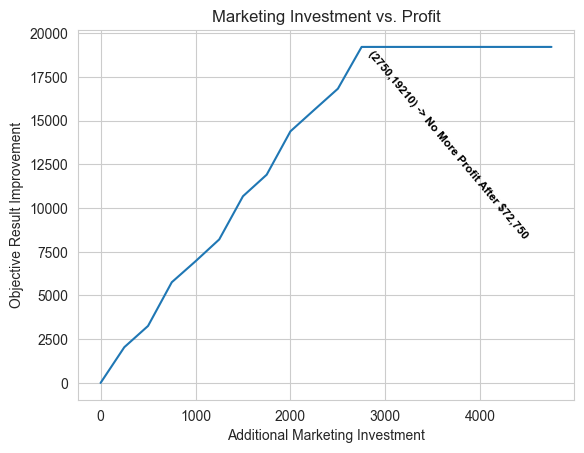

In [61]:
#plt.plot(budget_test_list, [i/1000 for i in objective_result_list[1:]])

sns.set_style("whitegrid")
sns.lineplot(x=[i-70000 for i in budget_test_list], y=[(i)-(7777790.06) for i in objective_result_list[1:]])

plt.text(2750, 7797000.84-7777790.06, f"   (2750,{7797000-7777790}) -> No More Profit After $72,750", 
         horizontalalignment='left', 
         size='small', color='black', weight='semibold', 
         rotation = 310, rotation_mode = 'anchor')
plt.xlabel('Additional Marketing Investment')
plt.ylabel('Objective Result Improvement')
plt.title('Marketing Investment vs. Profit')
plt.show()